In [ ]:
import pandas as pd 
from pathlib import Path

N5_BASE = "outputs/0_final_results/MATH-full_dt.math/chatgpt1106/model_selection_prompts/modif_n5_baseline_0.5_0.8.jsonl"
N5_RIMS_PATHS = list(Path("outputs/0_final_results").glob("MATH-full_dt.math/chatgpt1106/*/modif_n5_rims_*.jsonl"))

df_base = pd.read_json(N5_BASE, lines=True)
rims_df_d = {"/".join(path.parts[-2:]): pd.read_json(path, lines=True) for path in N5_RIMS_PATHS}

df_base.shape, {k: v.shape for k, v in rims_df_d.items()}   

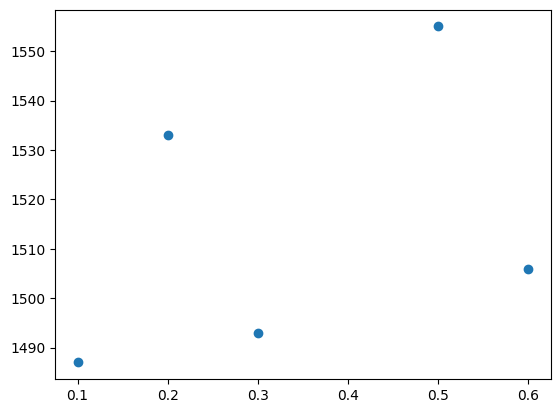

In [14]:
# SC5 math results 
t = ["base0.5_0.8", .1, .2, .3, .5, .6]
acc = [2582, 2506, 2552, 2512, 2574, 2525]
succ = [1563, 1487, 1533, 1493, 1555, 1506]
# fails = [0, 2, 8, 1, 5, 10]


# plot scatter plot
import matplotlib.pyplot as plt
# plt.scatter(t[1:], acc[1:])
plt.scatter(t[1:], succ[1:])

In [76]:
def check(majority_ans, majvote_ans):
    # did majority_ans came from majvote_ans?
    majvote_submitted = False
    if isinstance(majvote_ans, list):
        if isinstance(majority_ans, list):
            for a in majority_ans:
                if a in majvote_ans:
                    majvote_submitted = True
                    break
        elif majority_ans is not None:
            majvote_submitted = (majority_ans in majvote_ans)
        else:
            raise DONOTREACHHERE
    else:
        majvote_submitted = False
    return majvote_submitted

In [77]:
def analyze_selection_effect(df, return_flag=False):
    selection_runs = df.majvote_ans.apply(lambda lst: lst.count(None)>0 if isinstance(lst, list) else False)
    majvote_ans_are_submitted = df.apply(lambda row: check(row.majority_ans, row.majvote_ans), axis=1)  & selection_runs
    selection_ans_changed_answer = df.apply(lambda row: check(row.majority_ans, row.candid_answers), axis=1) & (~majvote_ans_are_submitted) & selection_runs
    na = df.majority_ans.isna() | df.majvote_ans.isna() | df.candid_answers.isna() | df.majority_ans.apply(lambda x: x==[])
    res = {
            "total_rows": len(df),
            "selection_occurred": selection_runs, #.sum(),
            "majvote_ans_are_submitted": majvote_ans_are_submitted, # .sum(),
            "selection_ans_changed_final_submission": selection_ans_changed_answer, #.sum(),
            "na_or_majority_ans_emptylist": na.sum(),
            # "diff": (majvote_ans_are_submitted | selection_ans_changed_answer) & (~selection_runs), # majvote_ans_are_submitted.sum() + selection_ans_changed_answer.sum() - selection_runs.sum(),
            # "edge_cases": (selection_runs &  (~majvote_ans_are_submitted) & (~selection_ans_changed_answer)),
        }
    if not return_flag:
        for key in ["selection_occurred", "majvote_ans_are_submitted", "selection_ans_changed_final_submission", ]: # diff, edge_cases
            res[key] = res[key].sum()

    return res

In [78]:
from pprint import pprint

res_base = analyze_selection_effect(df_base)
res_rims_d = {k: analyze_selection_effect(v) for k, v in rims_df_d.items()}
print("base")
pprint(res_base)
sort_rims = sorted(list(res_rims_d.keys()), key=lambda txt: txt.split("/")[-1])

for k in sort_rims:
    pprint(k)
    pprint(res_rims_d[k])

res_base_flags = analyze_selection_effect(df_base, return_flag=True)
res_rims_d_flags = {k: analyze_selection_effect(v, return_flag=True) for k, v in rims_df_d.items()}

df_base[df_base.majority_ans.apply(lambda a: a==[])].loc[:, ["candid_answers", "answer", "majority_ans"]]


base
{'majvote_ans_are_submitted': 2459,
 'na_or_majority_ans_emptylist': 336,
 'selection_ans_changed_final_submission': 980,
 'selection_occurred': 3775,
 'total_rows': 4996}
'rims_math_p2c-cot.pal-p2c.pal-cot__.txt1/n5_rims_T0.1.jsonl'
{'majvote_ans_are_submitted': 2187,
 'na_or_majority_ans_emptylist': 26,
 'selection_ans_changed_final_submission': 1561,
 'selection_occurred': 3773,
 'total_rows': 4995}
'rims_math_p2c-cot.pal-p2c.pal-cot__.txt/n5_rims_T0.1.jsonl'
{'majvote_ans_are_submitted': 2155,
 'na_or_majority_ans_emptylist': 23,
 'selection_ans_changed_final_submission': 1596,
 'selection_occurred': 3772,
 'total_rows': 4995}
'rims_math_p2c-cot.pal-p2c.pal-cot__.txt1/n5_rims_T0.2.jsonl'
{'majvote_ans_are_submitted': 2501,
 'na_or_majority_ans_emptylist': 308,
 'selection_ans_changed_final_submission': 958,
 'selection_occurred': 3767,
 'total_rows': 4988}
'rims_math_p2c-cot.pal-p2c.pal-cot__.txt/n5_rims_T0.2.jsonl'
{'majvote_ans_are_submitted': 2481,
 'na_or_majority_ans_empt

,candid_answers,answer,majority_ans
44,"[$\boxed{\frac{1}{12}}$, $\boxed{\frac{6}{7}}$...",\frac{1}{12},[]
108,"[$(1,6)$, $(6,6)$, None, $\boxed{(9, 5)}$, $\n...","(2,12)",[]
133,"[18.0, $5+3\sqrt{5}$, $\n\nFinal Answer: $, $\...",18,[]
160,"[\( \frac{243}{8} \), \(\frac{729}{64}\), $\fr...",\frac{243}{8},[]
200,"[9, $\boxed{0}$, $\boxed{5}$, 100.0, $\boxed{1...",29,[]
...,...,...,...
4983,"[$\boxed{\left(\frac{1}{\sqrt{2}}, -\frac{1}{2...","\left( \frac{1}{\sqrt{2}}, \frac{1}{\sqrt{2}} ...",[]
4985,[\[\mathbf{b} = \begin{pmatrix} 4 \\ 7 \end{pm...,\begin{pmatrix} 2/5 \\ -1/5 \end{pmatrix},[]
4986,"[$ and $, $\n\nSince the angle between vectors...",55^\circ,[]
4990,"[$\boxed{\text{All real numbers}}$, \(x\), $\b...","7, -2, \text{ and } -5",[]


In [80]:
keys = sort_rims

corrects = [
2549,
2495,
2486,
2530,
2516,
2502,
2526,
2538,
2548,
2516,
2533,
]

lucks = [ 
    res_rims_d[k]["na_or_majority_ans_emptylist"] for k in sort_rims
]


diff_from_bases = [corrects[0]-i for i in corrects[1:]]
luck_surpluses = [l - lucks[0] for l in lucks[1:]]

for d, l, name in zip(diff_from_bases, luck_surpluses, sort_rims):
    print(d, l, name)

54 -3 rims_math_p2c-cot.pal-p2c.pal-cot__.txt1/n5_rims_T0.1.jsonl
63 282 rims_math_p2c-cot.pal-p2c.pal-cot__.txt/n5_rims_T0.1.jsonl
19 262 rims_math_p2c-cot.pal-p2c.pal-cot__.txt1/n5_rims_T0.2.jsonl
33 -14 rims_math_p2c-cot.pal-p2c.pal-cot__.txt/n5_rims_T0.2.jsonl
47 -15 rims_math_p2c-cot.pal-p2c.pal-cot__.txt1/n5_rims_T0.3.jsonl
23 302 rims_math_p2c-cot.pal-p2c.pal-cot__.txt/n5_rims_T0.3.jsonl
11 308 rims_math_p2c-cot.pal-p2c.pal-cot__.txt1/n5_rims_T0.5.jsonl
1 -4 rims_math_p2c-cot.pal-p2c.pal-cot__.txt/n5_rims_T0.5.jsonl
33 -17 rims_math_p2c-cot.pal-p2c.pal-cot__.txt1/n5_rims_T0.6.jsonl


In [ ]:
# txt1 prompt 에 좀더 희망이 있어보임
# txt prompt는 greedy에서 어떤 결과를 보였었나?

# chatgpt 1106, gpt4turbo 모두 txt1 prompt결과가 더 일관성 있고 좋았다.
# 그러므로 txt1 prompt에 대해서 `get_concordant_answer_n(candid_answers) == []` 인 경우, candid_answers 에서 하나 고르도록 하지 말고, selection answers 중에서 하나 고르도록 고쳐보자. (이 편이 차이를 부각하기 더 좋다. candid에서 샘플링할 경우 majvote에 의해서 결과가 희석될 것.) 


# diff to catchup / lucks surplus / rims prompts+temp
# 19 262 rims_math_p2c-cot.pal-p2c.pal-cot__.txt1/n5_rims_T0.2.jsonl
# 33 -14 rims_math_p2c-cot.pal-p2c.pal-cot__.txt/n5_rims_T0.2.jsonl


# 11 308 rims_math_p2c-cot.pal-p2c.pal-cot__.txt1/n5_rims_T0.5.jsonl
# 1 -4 rims_math_p2c-cot.pal-p2c.pal-cot__.txt/n5_rims_T0.5.jsonl

1. math rims가 약한 부분을 보강해야함. 약한 부분에 해당하는 fewshot을 마련해서 넣어줘야함 
2. 이를 위해서 분야별 오류율이 어떻게 변하는지 트래킹 가능해야함 (정답 boolean 이랑 같이 봐야함). 일단은 sc5에서 어떤 부분이 박살났는지, 그리고 T0랑 양상이 어떻게 다른지 봐야함. 
3. 그냥 t0.5+0.8 조건에서 실험해봐야함

## Analyze 
* strength/weakpoints of math-rims
* strength/weakpoints of simple-greedy


In [32]:
import pandas as pd 
from utils.math_util import math_check_answer
from tqdm import tqdm
tqdm.pandas()

# filedirs 
greedyres_d = dict(
    BASE="outputs/0_final_results/greedy_decoded_results/MATH-full_dt.math/chatgpt1106/model_selection_prompts/n1_baseline.jsonl",
    MATH_RIMS = "outputs/0_final_results/greedy_decoded_results/MATH-full_dt.math/chatgpt1106/rims_math_p2c-cot.pal-p2c.pal-cot__.txt/04_01_00_42_44.jsonl",
    MATH_RIMS1 = "outputs/0_final_results/greedy_decoded_results/MATH-full_dt.math/chatgpt1106/rims_math_p2c-cot.pal-p2c.pal-cot__.txt1/04_01_12_12_37.jsonl",
    MATH_RIMS_A1 = "outputs/0_final_results/greedy_decoded_results/MATH-full_dt.math/chatgpt1106/rims_math_p2c-cot.pal-p2c.txt/rims_T0.0.jsonl", 
    MATH_RIMS_A2 = "outputs/0_final_results/greedy_decoded_results/MATH-full_dt.math/chatgpt1106/rims_math_p2c-cot.pal-p2c.txt1/rims_T0.0.jsonl"
    )

df = pd.read_json(greedyres_d["MATH_RIMS"], lines=True)
df.columns
# df["iscorrect"] = df.apply(lambda row: math_check_answer(row["answer"], row["majority_ans"]), axis=1 )


Index(['question', 'level', 'type', 'solution', 'answer', 'ansmap', 'solmap',
       'plan', 'selection_or_rims', 'majority_ans', 'prompt_file',
       'inference_mode', 'index'],
      dtype='object')

In [61]:
sc_res_d = dict(
    BASE = "outputs/0_final_results/MATH-full_dt.math/chatgpt1106/model_selection_prompts/modif_n5_baseline_0.5_0.8.jsonl",
    MATH_RIMS = "outputs/0_final_results/MATH-full_dt.math/chatgpt1106/rims_math_p2c-cot.pal-p2c.pal-cot__.txt/modif_n5_T0.5_0.5only.jsonl",
    MATH_RIMS1 = "outputs/0_final_results/MATH-full_dt.math/chatgpt1106/rims_math_p2c-cot.pal-p2c.pal-cot__.txt1/n5_rims_T0.5_0.5_0.8.jsonl",
    MATH_RIMS_A1 = "outputs/0_final_results/MATH-full_dt.math/chatgpt1106/rims_math_p2c-cot.pal-p2c.txt/n5_rims_T0.5__0508", 
    MATH_RIMS_A2 = "outputs/0_final_results/MATH-full_dt.math/chatgpt1106/rims_math_p2c-cot.pal-p2c.txt1/n5_rims_T0.5__0508",
)

In [30]:
# num nones
gr_df_d = {k:pd.read_json(v, lines=True) for k,v in greedyres_d.items()}
vc = {k:v.majority_ans.apply(type).value_counts() for k,v in gr_df_d.items()}
vc


# base ~ 70 none / rims 380~440 nones but outperforming! wtf?

{'BASE': majority_ans
 <class 'str'>         3506
 <class 'float'>       1423
 <class 'NoneType'>      70
 Name: count, dtype: int64,
 'MATH_RIMS': majority_ans
 <class 'float'>       2597
 <class 'str'>         1972
 <class 'NoneType'>     430
 Name: count, dtype: int64,
 'MATH_RIMS1': majority_ans
 <class 'float'>       2716
 <class 'str'>         1899
 <class 'NoneType'>     384
 Name: count, dtype: int64,
 'MATH_RIMS_A1': majority_ans
 <class 'float'>       2570
 <class 'str'>         1959
 <class 'NoneType'>     470
 Name: count, dtype: int64,
 'MATH_RIMS_A2': majority_ans
 <class 'float'>       2616
 <class 'str'>         1943
 <class 'NoneType'>     440
 Name: count, dtype: int64}

In [33]:
# do scoring
scored_d = {k: df.progress_apply(lambda row: math_check_answer(row["answer"], row["majority_ans"]), axis=1 ) for k, df in gr_df_d.items()}

100%|██████████| 4999/4999 [00:29<00:00, 167.05it/s]


In [147]:
# scores
scores = {k: v for k,v in scored_d.items()}
for k in scores.keys():
    gr_df_d[k]["iscorrect"] = scores[k]
for k,v in scores.items():
    if k == "BASE":
        print(k, v.sum())
    else:
        print(k, v.sum()-75)

BASE 2092
MATH_RIMS 2117
MATH_RIMS1 2121
MATH_RIMS_A1 2112
MATH_RIMS_A2 2113


In [ ]:
# apply good method chosen for each row
df = gr_df_d["BASE"]
# df.groupby("type").iscorrect.count()

def majority_voted_lines(row):
    res = False
    if "majority_vote" in row.selection_or_rims.keys():
        res = row.selection_or_rims["majority_vote"]
    return res 

def error_lines(row):
    res = False
    if "error" in row.selection_or_rims.keys():
        res = row.selection_or_rims["error"]
    elif "good_method" in row.keys() and row["good_method"] is None or row["good_method"] not in "pal p2c cot":
        res = True
    elif "selection_or_rims" in row.keys() and row["selection_or_rims"] is None:
        res = True
    return res

def error_lines_n(row):
    raise NotImplementedError()


def majvoted(df):
    err_mask = df.apply(error_lines, axis=1)
    majv_mask = df.apply(majority_voted_lines, axis=1)
    return df[(~err_mask)&majv_mask]

def selection_chosen(df):
    err_mask = df.apply(error_lines, axis=1)
    majv_mask = df.apply(majority_voted_lines, axis=1)
    df = df[~(err_mask | majv_mask)]
    df["chosen_method"] = df.selection_or_rims.apply(lambda d: d["good_method"] if "good_method" in d.keys() else None)
    df = df[df.chosen_method.apply(lambda x: x in "cot pal p2c" if isinstance(x, str) else False) ]
    return df

def selection_chosen_n(df):
    raise NotImplementedError()


selection_majv_d = {k:[selection_chosen(v), majvoted(v)] for k,v in gr_df_d.items()}



In [146]:
base_maj_corrects = selection_majv_d["BASE"][1].iscorrect.sum()
base_sel_corrects = selection_majv_d["BASE"][0].iscorrect.sum()
for k, df_s_m in selection_majv_d.items():
    # print(k, df_s_m[0].shape, df_s_m[1].shape, len(df_s_m[0])+len(df_s_m[1]))
    print(f"{k:<15}: selection: {len(df_s_m[0]):<5} majvote: {len(df_s_m[1]):<5} | diff(majvote_correct): {df_s_m[1].iscorrect.sum() - base_maj_corrects:<4} | diff(sel_correct): {df_s_m[1].iscorrect.sum() - base_sel_corrects:<4} ")

BASE           : selection: 2106  majvote: 2449  | diff(majvote_correct): 0    | diff(sel_correct): 1368 
MATH_RIMS      : selection: 2292  majvote: 2638  | diff(majvote_correct): 75   | diff(sel_correct): 1443 
MATH_RIMS1     : selection: 2322  majvote: 2638  | diff(majvote_correct): 75   | diff(sel_correct): 1443 
MATH_RIMS_A1   : selection: 2264  majvote: 2638  | diff(majvote_correct): 75   | diff(sel_correct): 1443 
MATH_RIMS_A2   : selection: 2285  majvote: 2638  | diff(majvote_correct): 75   | diff(sel_correct): 1443 


In [163]:
# by type
counts = selection_majv_d["BASE"][0].groupby("type").question.count().array 
base = selection_majv_d["BASE"][0].groupby("type").iscorrect.sum()
print("BASE is good at (selecting...)")
print(base/counts)
print()

for k, (df_sel, df_maj) in selection_majv_d.items():
    print(k)
    print(((df_sel.groupby('type').iscorrect.sum() - base))/counts)
    print(((df_sel.groupby('type').iscorrect.sum() - base) ).sum())
    print()
        

BASE is good at (selecting...)
type
Algebra                   0.198238
Counting & Probability    0.163265
Geometry                  0.177686
Intermediate Algebra      0.142549
Number Theory             0.103627
Prealgebra                0.260870
Precalculus               0.154122
Name: iscorrect, dtype: float64

BASE
type
Algebra                   0.0
Counting & Probability    0.0
Geometry                  0.0
Intermediate Algebra      0.0
Number Theory             0.0
Prealgebra                0.0
Precalculus               0.0
Name: iscorrect, dtype: float64
0

MATH_RIMS
type
Algebra                   0.112335
Counting & Probability    0.036735
Geometry                 -0.057851
Intermediate Algebra     -0.051836
Number Theory             0.129534
Prealgebra                0.056522
Precalculus              -0.125448
Name: iscorrect, dtype: object
25

MATH_RIMS1
type
Algebra                   0.063877
Counting & Probability    0.089796
Geometry                 -0.037190
Intermediate Al

In [174]:
counts = selection_majv_d["BASE"][0].groupby("chosen_method").question.count()
base = selection_majv_d["BASE"][0].groupby("chosen_method").iscorrect.sum()
print("BASE is good at (selecting...)")
print(pd.DataFrame( dict( correct =base, counts=counts)) )
print()

for k, (df_sel, df_maj) in selection_majv_d.items():
    print(k)
    counts_diff = df_sel.groupby('chosen_method').iscorrect.count() - counts 
    correct_diff =  df_sel.groupby('chosen_method').iscorrect.sum() - base
    print(pd.DataFrame(dict(correct_diff=correct_diff, counts_diff=counts_diff)))
    print(((df_sel.groupby('chosen_method').iscorrect.sum() - base)).sum())
    print()

BASE is good at (selecting...)
               correct  counts
chosen_method                 
cot                302    1844
p2c                 11      63
pal                 49     199

BASE
               correct_diff  counts_diff
chosen_method                           
cot                       0            0
p2c                       0            0
pal                       0            0
0

MATH_RIMS
              correct_diff  counts_diff
chosen_method                          
                       NaN          NaN
cot                  -63.0       -377.0
p2c                   86.0        490.0
pal                    2.0         61.0
25.0

MATH_RIMS1
               correct_diff  counts_diff
chosen_method                           
                        NaN          NaN
cot                   -61.0       -218.0
p2c                    69.0        347.0
pal                    21.0         86.0
29.0

MATH_RIMS_A1
               correct_diff  counts_diff
chosen_method              

In [175]:
for k, (df_sel, df_maj) in selection_majv_d.items():
    selection_majv_d[k][0]["hash"] = df_sel.chosen_method + "_" + df_sel.type

counts = selection_majv_d["BASE"][0].groupby("hash").question.count()
base = selection_majv_d["BASE"][0].groupby("hash").iscorrect.sum()
print("BASE is good at (selecting...)")
print(pd.DataFrame( dict( correct =base, counts=counts)) )
print()

for k, (df_sel, df_maj) in selection_majv_d.items():
    print(k)
    counts_diff = df_sel.groupby('hash').iscorrect.count() - counts 
    correct_diff =  df_sel.groupby('hash').iscorrect.sum() - base
    print(pd.DataFrame(dict(correct_diff=correct_diff, counts_diff=counts_diff)))
    print(((df_sel.groupby('hash').iscorrect.sum() - base)).sum())
    print()



BASE is good at (selecting...)
                            correct  counts
hash                                       
cot_Algebra                      74     411
cot_Counting & Probability       33     207
cot_Geometry                     37     195
cot_Intermediate Algebra         54     402
cot_Number Theory                14     176
cot_Prealgebra                   54     214
cot_Precalculus                  36     239
p2c_Algebra                       2      12
p2c_Counting & Probability        2       9
p2c_Geometry                      1       6
p2c_Intermediate Algebra          2      21
p2c_Number Theory                 0       3
p2c_Precalculus                   4      12
pal_Algebra                      14      31
pal_Counting & Probability        5      29
pal_Geometry                      5      41
pal_Intermediate Algebra         10      40
pal_Number Theory                 6      14
pal_Prealgebra                    6      16
pal_Precalculus                   3      28



In [ ]:
# looks like boosting cot selection will enhance rims results. What was the original success rate of each method according to the type?

from typing import Literal
def ansmap_iscorrect(method:Literal["cot", "pal", "p2c"], row=None):
    res = False
    if error_lines(row):
        pass
    elif "ansmap" not in row.keys():
        pass 
    elif isinstance(row.ansmap, dict):
        submission = row.ansmap[method]
        res = math_check_answer(row.answer, submission)
    else:
        pass
    return res 

base_df = gr_df_d["BASE"]
base_df["cot_correct"] = base_df.progress_apply(lambda row: ansmap_iscorrect("cot", row), axis=1)
base_df["pal_correct"] = base_df.progress_apply(lambda row: ansmap_iscorrect("pal", row), axis=1)
base_df["p2c_correct"] = base_df.progress_apply(lambda row: ansmap_iscorrect("p2c", row), axis=1)
gr_df_d["BASE"] = base_df  


In [188]:

success_rate_each = pd.DataFrame(
dict( 
    cot = base_df.groupby("type").cot_correct.mean().round(3),
    pal = base_df.groupby("type").pal_correct.mean().round(3),
    p2c = base_df.groupby("type").p2c_correct.mean().round(3),
)
)

print("total")
print(base_df.loc[:, ["cot_correct", "pal_correct", "p2c_correct"]].mean(axis=1) )

print("type")
print(success_rate_each)


100%|██████████| 4999/4999 [00:36<00:00, 135.14it/s]

total
0       1.000000
1       0.666667
2       0.000000
3       0.333333
4       0.000000
          ...   
4994    0.000000
4995    0.000000
4996    0.000000
4997    0.000000
4998    0.000000
Length: 4999, dtype: float64
type
                          cot    pal    p2c
type                                       
Algebra                 0.392  0.447  0.463
Counting & Probability  0.278  0.340  0.382
Geometry                0.273  0.215  0.182
Intermediate Algebra    0.151  0.190  0.142
Number Theory           0.269  0.581  0.592
Prealgebra              0.490  0.521  0.564
Precalculus             0.161  0.123  0.088
